In [3]:

import numpy as np
import scipy as sp
from astropy.io import fits as pyfits
from astropy.table import Table
import desispec.io
#from desispec.interpolation import resample_flux
#from desitarget.targetmask import desi_mask
#import sys
import os
import scipy.optimize as scpo
import matplotlib.pyplot as plt

import fitsio

# Desi catalog test
import glob
from itertools import compress
import healpy

In [ ]:
####  Catalog cutter eBoss

file = '/work3/desi_lya/data/eBOSS/dr15_all/DR14Q_v4_4.fits' # Add here the filename, include the full path if necesary
output = '/work/sfbeltranv/DR14_mini/DR14Q_v4_4m.fits'
hdul = pyfits.open(file)
data = hdul[1].data
hdul.info()

# Nor: Origina size, Nnew: new size for the catalog (in overall items)
Nor = len(data)
Nnew = 600

# Random Mask of Nnew items from the Nor items of the orignal catalog
w = np.random.choice(Nor,Nnew,replace=False)

if os.path.exists(output):
  os.remove(output)

# Mask set in the catalog
hdul[1].data = data[w]
hdul.writeto(output)   # change name to the desired one.
hdul.close()
print('\n\nDone writing.\n')


hdul = pyfits.open( output )
data = hdul[1].data
hdul.info()
hdul.close() 
print('\nDone with final size= ', len(data) )


In [ ]:
####  Catalog cutter Desi

file = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/zcat.fits' # Add here the filename, include the full path if necesary
output = '/work/sfbeltranv/DR14_mini/zcat_m.fits'
hdul = pyfits.open(file)
data = hdul[1].data
hdul.info()

# Nor: Origina size, Nnew: new size for the catalog (in overall items)
Nor = len(data)
Nnew = 600

# Random Mask of Nnew items from the Nor items of the orignal catalog
w = np.random.choice(Nor,Nnew,replace=False)

if os.path.exists(output):
  os.remove(output)

# Mask set in the catalog
hdul[1].data = data[w]
hdul.writeto(output)   # change name to the desired one.
hdul.close()
print('\n\nDone writing.\n')


hdul = pyfits.open( output )
data = hdul[1].data
hdul.info()
hdul.close() 
print('\nDone with final size= ', len(data) )

In [ ]:
#### Catalog loading and mask example:

catalog=Table.read('/work/sfbeltranv/DR14_mini/DR14Q_v4_4m.fits')
w=(catalog['THING_ID']>0) & (catalog['Z']>2) & (catalog['Z']<4) & (catalog['RA']!=catalog['DEC'])& (catalog['RA']>0) & (catalog['DEC']>0)
reduced_cat=catalog[w]

# Final reduced_cat size:
print(( np.sum(w) ))
print( len(reduced_cat) )


In [31]:

#####################################
# Load QSO from plates     eBoss
### Parameters
path_spec      = '/work3/desi_lya/data/eBOSS/dr15_all/spplates'
path_drq       = '/work/sfbeltranv/DR14_mini/DR14Q_v4_4m.fits'

# for line correction (later)
#path_lines     = '/work3/desi_lya/data/eBOSS/dr12_all/dr16-line-sky-mask.txt'

zmin = 2
zmax = 4

In [43]:

def load_eBoss(path_drq, path_spec, zmin, zmax):
   # eBoss Catalog load
   catalog = Table.read(path_drq)
   
   lya = 1200 # 1215.67 1200
   w = (catalog['THING_ID']>0) & (catalog['Z'] > zmin ) & (catalog['Z']< zmax ) & (catalog['RA']!=catalog['DEC'])& (catalog['RA']>0) & (catalog['DEC']>0)
   reduced_cat = catalog[w]
   reduced_cat = reduced_cat.group_by('PLATE')

   # thing_id = reduced_cat['THING_ID']
   fiberid = reduced_cat['FIBERID']
   plate = reduced_cat['PLATE']
   zqso = reduced_cat['Z']
   DEC = reduced_cat['DEC']
   RA = reduced_cat['RA']

   plate_list=[]
   for p,m in zip(reduced_cat['PLATE'],reduced_cat['MJD']):
        plate_list.append(str(p)+'/spPlate-'+str(p)+'-'+str(m)+'.fits')
   plate_list=np.unique(plate_list)

    #thisplate=plate_list[0].split("/")[1]  # Location
    #thisplate=plate_list[0].split("/")[0]  # Plate Number
   print('Found '+ str(  np.sum(w) ) + ' QSO spec. in catalog: '+ path_drq )
    
   spectra = []
   QSOloc = []
   ## begin for test
   for nplate in range ( 0, len(plate_list) ):
      plate1=pyfits.open( path_spec+'/'+plate_list[nplate].split("/")[1] )
      thisplate=plate_list[nplate].split("/")[0]  # Plate Number

      wp = plate == int( thisplate )
      ids_=fiberid[wp]
      zqso_=zqso[wp]
      DEC_ = DEC[wp]
      RA_ = RA[wp]
      
      nqsoPlate_= ids_.shape[0]
      print( str(nplate) + ': Loading '+ str(nqsoPlate_) +' QSO spec. from plate: '+ plate_list[nplate].split("/")[1] )
      # Reading data from plate
      plugmap = plate1['PLUGMAP'].data
      # Searching for fiber of qso in data
      wp = np.in1d(plugmap['FIBERID'],ids_)
      # Applying mask to select only QSO
      small_plugmap = plugmap[wp]

      #Get the spectra
      flux=plate1[0].data
      #Get the weight
      ivar=plate1[1].data

      #Get the wavelenght
      pltheader=plate1[0].header
      coeff0=pltheader['COEFF0']
      coeff1=pltheader['COEFF1']
      logwave=coeff0+coeff1*np.arange(flux.shape[1])
      for i in range(0,nqsoPlate_):
            w_ = (10**logwave)/(1+zqso_[i])
            w_crop = ( w_ >= 1040 ) & ( w_ <= lya )
            w_ = w_[w_crop]
            flx = flux[ids_[i]-1][w_crop]
            ivr = ivar[ids_[i]-1][w_crop]
            
            QSOloc.append( np.hstack(( zqso_[i], DEC_[i], RA_[i] )) )
            s=np.vstack( ( w_.conj().transpose(), flx.conj().transpose(), ivr.conj().transpose() ) )
            spectra.append( s )
   print('Reading done.')         
   return QSOloc, spectra


#####################################
# Load QSO from plates     eBoss
### Parameters
path_spec      = '/work3/desi_lya/data/eBOSS/dr15_all/spplates'
path_drq       = '/work/sfbeltranv/DR14_mini/DR14Q_v4_4m.fits'

# for line correction (later)
#path_lines     = '/work3/desi_lya/data/eBOSS/dr12_all/dr16-line-sky-mask.txt'

zmin = 2
zmax = 4

QSOloc_eBoss, spectra_eBoss = load_eBoss(path_drq, path_spec, zmin, zmax)



Found 233 QSO spec. in catalog: /work/sfbeltranv/DR14_mini/DR14Q_v4_4m.fits
0: Loading 1 QSO spec. from plate: spPlate-3701-55540.fits
1: Loading 1 QSO spec. from plate: spPlate-3753-55486.fits
2: Loading 1 QSO spec. from plate: spPlate-3762-55507.fits
3: Loading 1 QSO spec. from plate: spPlate-3765-55508.fits
4: Loading 1 QSO spec. from plate: spPlate-3802-55528.fits
5: Loading 1 QSO spec. from plate: spPlate-3817-55277.fits
6: Loading 1 QSO spec. from plate: spPlate-3850-55575.fits
7: Loading 1 QSO spec. from plate: spPlate-3851-55302.fits
8: Loading 1 QSO spec. from plate: spPlate-3854-55247.fits
9: Loading 1 QSO spec. from plate: spPlate-3874-55280.fits
10: Loading 1 QSO spec. from plate: spPlate-3878-55361.fits
11: Loading 1 QSO spec. from plate: spPlate-3879-55244.fits
12: Loading 1 QSO spec. from plate: spPlate-3926-55327.fits
13: Loading 1 QSO spec. from plate: spPlate-3933-55335.fits
14: Loading 1 QSO spec. from plate: spPlate-3946-55659.fits
15: Loading 1 QSO spec. from plate

137: Loading 1 QSO spec. from plate: spPlate-6018-56067.fits
138: Loading 1 QSO spec. from plate: spPlate-6049-56091.fits
139: Loading 1 QSO spec. from plate: spPlate-6063-56098.fits
140: Loading 1 QSO spec. from plate: spPlate-6129-56301.fits
141: Loading 1 QSO spec. from plate: spPlate-6142-56219.fits
142: Loading 1 QSO spec. from plate: spPlate-6155-56245.fits
143: Loading 1 QSO spec. from plate: spPlate-6161-56238.fits
144: Loading 1 QSO spec. from plate: spPlate-6164-56181.fits
145: Loading 1 QSO spec. from plate: spPlate-6167-56189.fits
146: Loading 1 QSO spec. from plate: spPlate-6168-56187.fits
147: Loading 2 QSO spec. from plate: spPlate-6191-56248.fits
148: Loading 1 QSO spec. from plate: spPlate-6317-56448.fits
149: Loading 1 QSO spec. from plate: spPlate-6406-56330.fits
150: Loading 2 QSO spec. from plate: spPlate-6412-56358.fits
151: Loading 1 QSO spec. from plate: spPlate-6442-56369.fits
152: Loading 2 QSO spec. from plate: spPlate-6468-56311.fits
153: Loading 1 QSO spec.

In [2]:
def chi2( alpha, *args ):
   a,b = alpha
   w,flux,ivar = args
   return np.sum( (( flux - (a*w+b) )**2 ) * ivar )

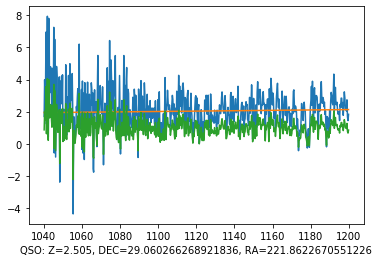

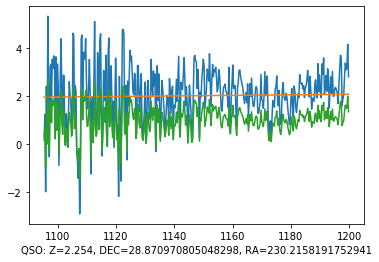

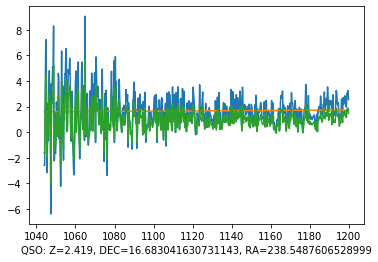

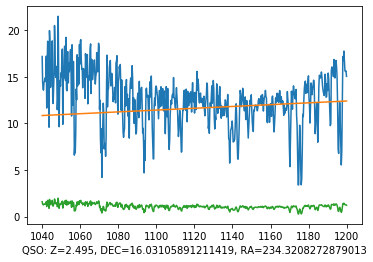

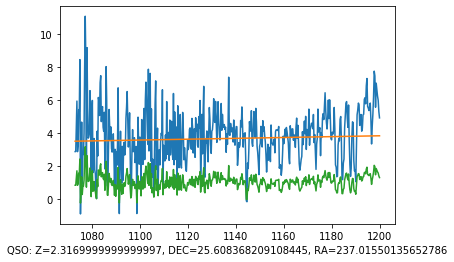

In [40]:
#### One QSO ploting example

for nspectra in range(10,15):
   # nspectra = 100
   s = spectra_eBoss[ nspectra ]
   z, dec, ra = QSOloc_eBoss[nspectra]
   w_ = s[0]
   flux_ = s[1]
   ivar_ = s[2]
   param = scpo.minimize(chi2, (1,1), args=(w_,flux_,ivar_), method='COBYLA' ); #COBYLA
   delta_ = flux_ / (param.x[0]*w_+param.x[1])

   plt.plot(w_,flux_)
   plt.plot(w_,(param.x[0]*w_+param.x[1]))
   plt.plot(w_, delta_ )

   plt.xlabel( 'QSO: Z=' + str( z) + ', DEC=' + str( dec) +', RA=' + str( ra)  )
   plt.show()



Text(0.5, 0, '$Wavelenght\\, (\\AA)$')

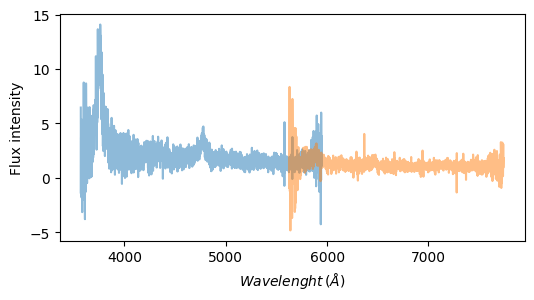

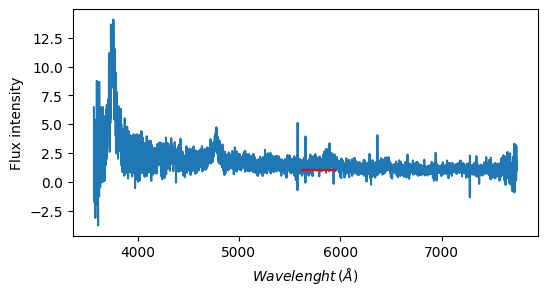

In [94]:
#####################################
# Load QSO from plates     Desi
### Parameters
path_spec      = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/spectra-16'
path_zcat      = '/work/sfbeltranv/DR14_mini/zcat_m.fits'

# for line correction (later)
#path_lines     = '/work3/desi_lya/data/eBOSS/dr12_all/dr16-line-sky-mask.txt'

zmin = 2
zmax = 4

catalog = Table.read(path_zcat)


file = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/spectra-16/10/1005/spectra-16-1005.fits' 
spec = Table.read( file )
#spec

h = pyfits.open( file )

h[0].header[4]

spectra_base= desispec.io.read_spectra( file )

from scipy.signal import medfilt
def plotspec(spectra, i, truewave=None, trueflux=None, color=['b','r','y'],nfilter=11,label=None):
    plt.plot(spectra.wave['b'], medfilt(spectra.flux['b'][i], nfilter), color=color[0], alpha=0.5,label=label)
    plt.plot(spectra.wave['r'], medfilt(spectra.flux['r'][i], nfilter), color=color[1], alpha=0.5)
    plt.plot(spectra.wave['z'], medfilt(spectra.flux['z'][i], nfilter), color=color[2], alpha=0.5)
    if truewave is not None and trueflux is not None:
        plt.plot(truewave, trueflux[i], 'k-')

    plt.axhline(0, color='k', alpha=0.2)
        
    ymax = np.max(spectra.flux['b'][i])
    ymin=0
        
    plt.ylim(ymin, ymax+3)
    plt.ylabel('Flux')
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
      
#plt.figure(figsize=(6,10),dpi=100)
#for i in range(5):
#    plt.subplot(5,1,i+1)
#    plotspec(spectra_base, i,label='BASE')

nqso = 34

plt.figure(figsize=(6,3),dpi=100)
plt.plot( spectra_base.wave['b'], spectra_base.flux['b'][nqso], alpha=0.5 )
plt.plot( spectra_base.wave['r'], spectra_base.flux['r'][nqso], alpha=0.5 )
plt.ylabel('Flux intensity')
plt.xlabel(r'$Wavelenght\, (\AA)$')

joint1 = np.in1d( spectra_base.wave['b'], spectra_base.wave['r'])
joint2 = np.in1d( spectra_base.wave['r'], spectra_base.wave['b'])

#plt.figure(figsize=(6,3),dpi=100)
#plt.plot( spectra_base.wave['b'][joint1], spectra_base.flux['b'][nqso][joint1], alpha=0.5 )
#plt.plot( spectra_base.wave['r'][joint2], spectra_base.flux['r'][nqso][joint2], alpha=0.5 )

#plt.figure(figsize=(6,3),dpi=100)
#plt.plot( spectra_base.wave['b'][joint1], spectra_base.ivar['b'][nqso][joint1]*spectra_base.flux['b'][nqso][joint1], alpha=0.5 )
#plt.plot( spectra_base.wave['r'][joint2], spectra_base.ivar['r'][nqso][joint2]*spectra_base.flux['r'][nqso][joint2], alpha=0.5 )

intersec = ( spectra_base.ivar['b'][nqso][joint1]*spectra_base.flux['b'][nqso][joint1] + spectra_base.ivar['r'][nqso][joint2]*spectra_base.flux['r'][nqso][joint2] )
intersec = intersec /( spectra_base.ivar['b'][nqso][joint1] + spectra_base.ivar['r'][nqso][joint2] )

ll = np.concatenate( ( spectra_base.wave['b'][np.invert(joint1)] , spectra_base.wave['r'] ) )

flx = np.concatenate( \
    ( spectra_base.flux['b'][nqso][np.invert(joint1)], intersec, \
     spectra_base.flux['r'][nqso][np.invert(joint2)] ) )


plt.figure(figsize=(6,3),dpi=100)
plt.plot(ll,flx)
plt.plot( spectra_base.wave['b'][joint1], spectra_base.wave['b'][joint1]*0 +1, 'r' )

plt.ylabel('Flux intensity')
#plt.xlabel(r'$Wavelenght\, (\AA)$, $Z_{qso}=$'+str(spectra_base.Z[nqso])+'.')

intersec = ( spectra_base.ivar['b'][nqso][joint1] + spectra_base.ivar['r'][nqso][joint2] ) 
ivr = np.concatenate( ( spectra_base.ivar['b'][nqso][np.invert(joint1)], intersec, \
      spectra_base.ivar['r'][nqso][np.invert(joint2)] ) )

#plt.figure(figsize=(6,3),dpi=100)
#plt.plot(ll,ivr)
#plt.plot( spectra_base.wave['b'][joint1], spectra_base.wave['b'][joint1]*0 +1, 'r' )

plt.ylabel('Flux intensity')
plt.xlabel(r'$Wavelenght\, (\AA)$')

#plt.plot(  spectra_base.flux['b'][0], alpha=0.5 )
#plt.plot(  spectra_base.flux['r'][0], alpha=0.5 )


In [42]:
def splitID(fi_str):
   fi_str= fi_str.split("spectra-16-")[1]
   return fi_str.split(".fits")[0]


def load_Desi(path_zcat, path_spec, zmin, zmax):
   # Desi Catalog load, beginning of function
   catalog = Table.read(path_zcat)
   qso_string = catalog['SPECTYPE'][0]
   
   lya = 1200 # 1215.67 1200

   
   w = (catalog['SPECTYPE']==qso_string ) & (catalog['Z'] > zmin ) & (catalog['Z']< zmax ) & (catalog['RA']!=catalog['DEC'])& (catalog['RA']>0) & (catalog['DEC']>0)
   reduced_cat = catalog[w]

   nest = True
   in_nside = 16

   targetid = reduced_cat['TARGETID']
   zqso = reduced_cat['Z']
   DEC = reduced_cat['DEC'] * np.pi/180
   RA = reduced_cat['RA'] * np.pi/180

   heal_pix = healpy.ang2pix(in_nside, sp.pi/2.-DEC, RA, nest)
   plate_list = np.unique(heal_pix)
   fi = glob.glob(path_spec+'/*/*/spectra*.fits*')
   print('Found', len(fi), 'spectra files.\n')
   fi_fix = []
   for i in range( 0, len(fi)):
       fi_fix.append( splitID(fi[i]) )

   fi_fix =  np.array( list(map(int, fi_fix)) ) 
   
   print('Found '+ str(  np.sum(w) ) + ' QSO spec. in ' + str( len(plate_list) ) + ' files.' )
   
   spectra = []
   QSOloc = []
   
   ## begin for test
   for nplate in range( 0, len(plate_list) ):      # len(plate_list)
      thisplate = plate_list[ nplate ]
      wp = heal_pix == int( thisplate )
      
      ids_ = targetid[wp]
      zqso_= zqso[wp]
      DEC_ = DEC[wp]
      RA_ = RA[wp]
      heal_pix_ = heal_pix[wp]
      
      # heal_pix: From healpy.ang2pix
      # plate_list: Unique from healpy.ang2pix \n
      # fi_fix: Plate id from directory list
      # fi: All files from glob
      nqsoPlate_= ids_.shape[0]
      # print( str(nplate) + ': Loading '+ str(nqsoPlate_) +' QSO spec. from file: '+ [] )      
      wpf = fi_fix == thisplate
      index = wpf * np.arange( len(fi_fix) )
      index = np.squeeze( index[wpf] )
      
      #print( thisplate,  nqsoPlate_ , len(fi_fix) )
      
      # print( thisplate, fi_fix[index], nqsoPlate_, fi[index] )
      print( str(nplate) + ': Loading '+ str(nqsoPlate_) +' QSO spec. from file: '+  str(thisplate) )
      
      spectra_base = desispec.io.read_spectra( fi[index] )   
      
      joint1 = np.in1d( spectra_base.wave['b'], spectra_base.wave['r'])
      joint2 = np.in1d( spectra_base.wave['r'], spectra_base.wave['b'])
            
      ll = np.concatenate( ( spectra_base.wave['b'][np.invert(joint1)] , spectra_base.wave['r'] ) )

      for i in range(0,nqsoPlate_):
         
         w_ = (ll)/(1+zqso_[ i ])
         w_crop = ( w_ >= 1040 ) & ( w_ <= lya )
         w_ = w_[w_crop] 
         
         intersec = ( spectra_base.ivar['b'][ i ][joint1]*spectra_base.flux['b'][ i ][joint1] + spectra_base.ivar['r'][ i ][joint2]*spectra_base.flux['r'][ i ][joint2] )
         intersec = intersec /( spectra_base.ivar['b'][ i ][joint1] + spectra_base.ivar['r'][ i ][joint2] )

         flx = np.concatenate( ( spectra_base.flux['b'][ i ][np.invert(joint1)], intersec, \
               spectra_base.flux['r'][ i ][np.invert(joint2)] ) )
         flx = flx[w_crop]
         
         intersec = ( spectra_base.ivar['b'][ i ][joint1] + spectra_base.ivar['r'][ i ][joint2] ) 
         ivr = np.concatenate( ( spectra_base.ivar['b'][ i ][np.invert(joint1)], intersec, \
               spectra_base.ivar['r'][ i ][np.invert(joint2)] ) )
         ivr = ivr[w_crop]
      
         QSOloc.append( np.hstack(( zqso_[i], DEC_[i], RA_[i] )) ) 
         s=np.vstack( ( w_.conj().transpose(), flx.conj().transpose(), ivr.conj().transpose() ) )
         spectra.append( s )
   
   print('Reading done.')
   return QSOloc, spectra


path_zcat = '/work/sfbeltranv/DR14_mini/zcat_m.fits' 
path_spec = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/spectra-16'
zmin = 2.
zmax = 4.

QSOloc_Desi, spectra_Desi = load_Desi(path_zcat, path_spec, zmin, zmax)



Found 167 spectra files.

Found 233 QSO spec. in 84 files.
0: Loading 3 QSO spec. from file: 0
1: Loading 2 QSO spec. from file: 1
2: Loading 5 QSO spec. from file: 2
3: Loading 2 QSO spec. from file: 3
4: Loading 5 QSO spec. from file: 8
5: Loading 2 QSO spec. from file: 9
6: Loading 3 QSO spec. from file: 11
7: Loading 3 QSO spec. from file: 14
8: Loading 4 QSO spec. from file: 32
9: Loading 3 QSO spec. from file: 33
10: Loading 2 QSO spec. from file: 34
11: Loading 2 QSO spec. from file: 35
12: Loading 2 QSO spec. from file: 36
13: Loading 1 QSO spec. from file: 37
14: Loading 5 QSO spec. from file: 38
15: Loading 2 QSO spec. from file: 39
16: Loading 3 QSO spec. from file: 40
17: Loading 2 QSO spec. from file: 41
18: Loading 1 QSO spec. from file: 42
19: Loading 1 QSO spec. from file: 43
20: Loading 5 QSO spec. from file: 44
21: Loading 3 QSO spec. from file: 45
22: Loading 1 QSO spec. from file: 46
23: Loading 1 QSO spec. from file: 47
24: Loading 4 QSO spec. from file: 56
25: Loa

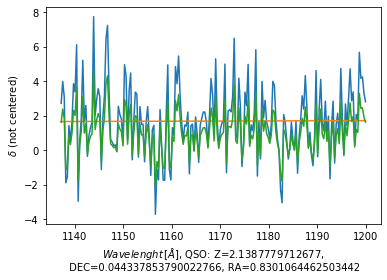

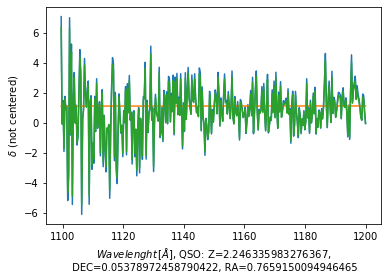

In [101]:
#### One QSO ploting example

for nspectra in range(0,2):
   # nspectra = 100
   s = spectra_Desi[ nspectra ]
   z, dec, ra = QSOloc_Desi[ nspectra ]
   w_ = s[0]
   flux_ = s[1]
   ivar_ = s[2]
   param = scpo.minimize(chi2, (1,1), args=(w_,flux_,ivar_), method='COBYLA' ); #COBYLA
   delta_ = flux_ / (param.x[0]*w_+param.x[1])

   plt.plot(w_,flux_)
   plt.plot(w_,(param.x[0]*w_+param.x[1]))
   plt.plot(w_, delta_ )

   plt.xlabel( r'$Wavelenght\, [\AA]$, QSO: Z=' + str( z) + ',\n DEC=' + str( dec) +', RA=' + str( ra)  )
   plt.ylabel( r'$\delta$ (not centered)' )
   plt.show()

